In [104]:
import yfinance as yf
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks", {'axes.grid': True})

In [105]:
def mono(ticker):
    
    

    # Generate first plot with Weekly Close

    analyzed_stock_daily = yf.Ticker(ticker)

    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    
    daily_closes = analyzed_stock_daily.history(
        period="5y", interval="1wk", actions=False).Close
    
    daily_vars = daily_closes.pct_change().dropna()

    z_scores_daily = (daily_vars - daily_vars.mean()) / daily_vars.std()
    

    # Generate first plot

    sns.lineplot(daily_closes, ax=ax1)
    ax1.title.set_text('Daily close')
    ax1.tick_params(axis='x', rotation=90)
    

    # Generate second plot with Z-Score

    sns.lineplot(z_scores_daily, ax=ax2)
    ax2.axhline(y=z_scores_daily.mean() + 2 * z_scores_daily.std(),
                color='orange',
                linestyle='--')
    ax2.axhline(y=z_scores_daily.mean() - 2 * z_scores_daily.std(),
                color='orange',
                linestyle='--')
    ax2.title.set_text('Daily Z-Score')
    ax2.tick_params(axis='x', rotation=90)

    fig.suptitle('Plots for ' + ticker)
    
    plt.show()
    

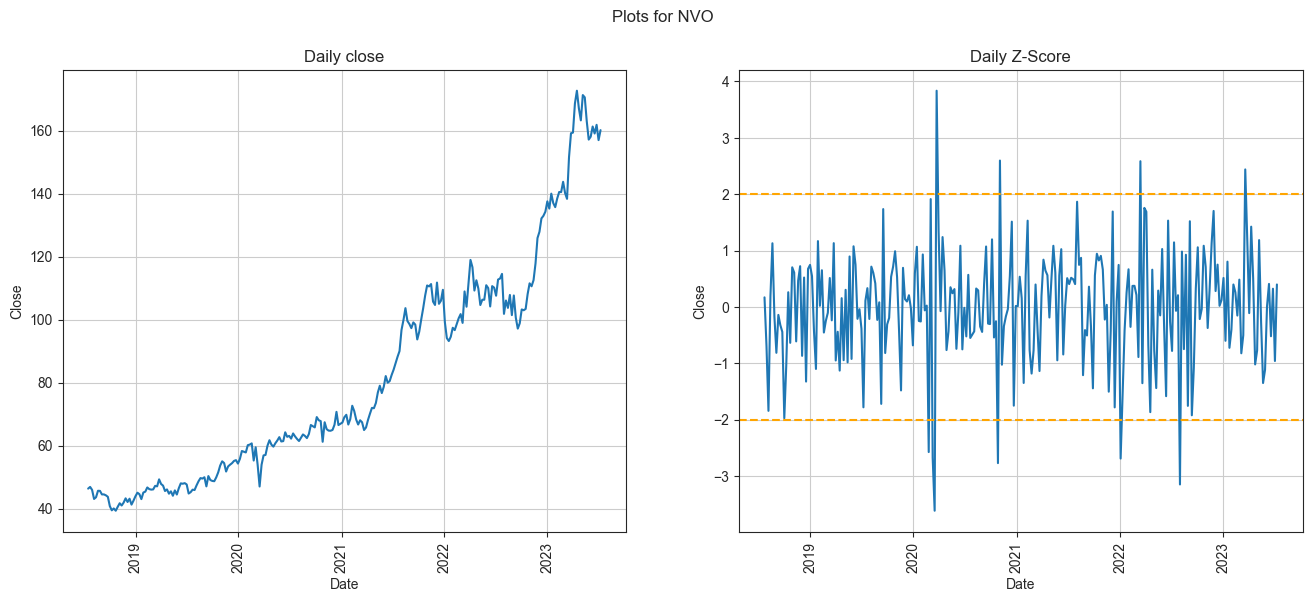

In [106]:
mono('NVO')

In [107]:
att = yf.Ticker('AAPL')

In [108]:
att.get_financials().T.columns

Index(['TaxEffectOfUnusualItems', 'TaxRateForCalcs', 'NormalizedEBITDA',
       'NetIncomeFromContinuingOperationNetMinorityInterest',
       'ReconciledDepreciation', 'ReconciledCostOfRevenue', 'EBIT',
       'NetInterestIncome', 'InterestExpense', 'InterestIncome',
       'NormalizedIncome', 'NetIncomeFromContinuingAndDiscontinuedOperation',
       'TotalExpenses', 'TotalOperatingIncomeAsReported',
       'DilutedAverageShares', 'BasicAverageShares', 'DilutedEPS', 'BasicEPS',
       'DilutedNIAvailtoComStockholders', 'NetIncomeCommonStockholders',
       'NetIncome', 'NetIncomeIncludingNoncontrollingInterests',
       'NetIncomeContinuousOperations', 'TaxProvision', 'PretaxIncome',
       'OtherIncomeExpense', 'OtherNonOperatingIncomeExpenses',
       'NetNonOperatingInterestIncomeExpense', 'InterestExpenseNonOperating',
       'InterestIncomeNonOperating', 'OperatingIncome', 'OperatingExpense',
       'ResearchAndDevelopment', 'SellingGeneralAndAdministration',
       'GrossProfit',

In [109]:
att.balance_sheet.T['Cash And Cash Equivalents']


2022-09-30    23646000000.0
2021-09-30    34940000000.0
2020-09-30    38016000000.0
2019-09-30    48844000000.0
Name: Cash And Cash Equivalents, dtype: object

In [110]:
att.balance_sheet.T['Total Debt']

2022-09-30    120069000000.0
2021-09-30    124719000000.0
2020-09-30    112436000000.0
2019-09-30    108047000000.0
Name: Total Debt, dtype: object

In [111]:
1.5156318463797305**(1/3)-1

0.14867695264734437

In [112]:
def get_indicator_growth_rate(ticker, indicator='fcf'):
    
    if indicator == 'cash_multiplier':
           
        indicator_values = yf.Ticker(ticker).balancesheet.T[['Cash And Cash Equivalents','Total Debt']]
        indicator_values['cash_multiplier']= indicator_values['Cash And Cash Equivalents']/indicator_values['Total Debt']
        indicator_values = indicator_values['cash_multiplier']
        
        return indicator_values[0] - indicator_values[-1]
    
    else:
        if indicator == 'revenue':
            indicator_values = yf.Ticker(ticker).get_financials().T['TotalRevenue'].values
            
        elif indicator == 'ebitda':
            indicator_values = yf.Ticker(ticker).get_financials().T['NormalizedEBITDA'].values
            
        else:
            indicator_values = yf.Ticker(ticker).cash_flow.T['Free Cash Flow'].values
        
        n_periods = len(indicator_values)
    
        return round((indicator_values[0]/indicator_values[-1])**(1/(n_periods-1))-1,4)

In [122]:
def result_metrics(ticker):
    
    
    revenue_growth = get_indicator_growth_rate(ticker,'revenue')
    ebitda_growth = get_indicator_growth_rate(ticker,'ebitda')
    fcf_growth = get_indicator_growth_rate(ticker)
    cash_multiplier = get_indicator_growth_rate(ticker,'cash_multiplier')
    
    
    
    
    
    dict_values = {
                    'Revenue Growth': revenue_growth, 
                   'EBITDA Growth': ebitda_growth, 
                   'FCF Growth': fcf_growth,
                   'Cash Multiplier': cash_multiplier
                   }

    return pd.DataFrame(dict_values, index=[ticker])

In [123]:
def dividend_metrics(ticker):
    
    analyzed_stock = yf.Ticker(ticker)

    # Payout ratio should be between 30% and 50%

    payout_ratio = analyzed_stock.info['payoutRatio']

    # I want the dividend median growth rate to be over 3%

    lfy_div = analyzed_stock.dividends.resample('A').sum().tail(5)[:-1]
    median_div_growth = lfy_div.pct_change().dropna().median()

    # I also want the (last) Dividend yield to be less than 5%
    closing_prices = analyzed_stock.history(
        period='6y').Close.resample('A').last()

    df_pre_div_yield = pd.concat([lfy_div, closing_prices], axis=1).dropna()

    last_dividend_yield = (df_pre_div_yield.Dividends /
                           df_pre_div_yield.Close).values[-1]

    # The formula is annual dividend per share dividend by free cash flow per share
    # I look for a number below 70%

    last_free_cash_flow = analyzed_stock.cash_flow.T['Free Cash Flow'].head(
        1).values[0]
    last_dividends_paid = analyzed_stock.cash_flow.T['Cash Dividends Paid'].head(
        1).values[0]

    free_cash_flow_payout = abs(last_dividends_paid/last_free_cash_flow)

    # I don't want junk

    quick_ratio = analyzed_stock.info['quickRatio']

    # what about last week z_score

    weekly_closes = analyzed_stock.history(
        period="5y", interval="1wk", actions=False).Close

    weekly_change = weekly_closes.pct_change().dropna()

    z_score = (weekly_change - weekly_change.mean())/weekly_change.std()

    dict_values = {'Last Price': analyzed_stock.history(period='1wk', interval='1d').Close[-1],
                   'Payout Ratio': payout_ratio,
                   'Div Growth': median_div_growth,
                   'Dividend Yield': last_dividend_yield,
                   'FCF Payout': free_cash_flow_payout,
                   'Quick Ratio': quick_ratio,
                   'W Z-Score': z_score[-1]}

    return pd.DataFrame(dict_values, index=[ticker])

In [124]:
result_metrics('MSFT')

,Revenue Growth,EBITDA Growth,FCF Growth,Cash Multiplier
MSFT,0.1774,0.2198,0.2001,0.036154
